***
<p style="text-align:left;">Reinforcement Learning
<span style="float:right;">Monday, 08. June 2020</span></p>

<p style="text-align:left;">Prof. S. Harmeling
<span style="float:right;">DUE 23:55 Monday, 15. June 2020</span></p>

---
<p style="text-align:center;"><b>Exercise set #7</b></p>

---

# 1. Semi-gradient TD(0)

In this exercise you will implement **semi-gradient TD(0)**, which is an approximate temporal-difference prediction algorithm.

In [1]:
import gym
import numpy as np

from abc import ABC, abstractmethod

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rcParams['figure.figsize'] = (8, 5)
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['grid.linestyle'] = 'dashed'
mpl.rcParams['grid.color'] = 'black'
mpl.rcParams['grid.alpha'] = 0.2

## 1000-state Random Walk Environment

We will apply semi-gradient TD(0) to the **1000-state Random Walk** environment from  
[Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html) by Sutton and Barto, p. 203.  

We implemented some parts of the environment in the code below. To fit in the gym library,  
the states are numbered from 0 to 999 (instead of 1 to 1000) and the start state is 499.  

Implement the ```step()``` method of the environment:

In [43]:
class RandomWalk1000(gym.Env):
    
    def __init__(self):
        super().__init__()
        self.observation_space = gym.spaces.Discrete(1000)
        self.action_space = gym.spaces.Discrete(0)
        self.state = None
    
    def reset(self):
        self.state = 499
        return self.state
    
    def step(self, action=None):
        #########################
        
        # number from 1 to 100 with uniform distribution
        n = np.random.randint(1, 101)
        print(n)
        
        if action:
            self.state += n
        else:
            self.state -=n
            
        if self.state < 0:
            self.state = 0
        if self.state > 999:
            self.state = 999
        
        if self.state == 0:
            reward = -1
            done = True
        elif self.state == 999:
            reward = 1
            done = True
        else:
            reward = 0
            done = False
        
        #########################
        
        info = {}
        return self.state, reward, done, info

Now, let's create an instance of the environment:

## Semi-gradient TD(0)

### Value functions

Remember that TD(0) is a *prediction* method, i.e. we use it to *approximate the value function* $v_\pi$ of a given policy $\pi$.  

In the previous exercises we studied *tabular* methods, where we could store the state-values in an array ```V```,  
since the state space was relatively small. For larger (or continuous) state spaces we may not be able to store  
all values explicitly, but instead we approximate the value function with *parameterized functions*:

$$\hat{v}_w(s) \approx v_\pi(s)$$

where $\hat{v}_w(s)$ is a parameterized function with weight vector $w \in \mathbb{R}^d$.  

In real-world applications $\hat{v}_w(s)$ may be a neural network, but we will take a look at the most basic class of functions,  
i.e. *linear functions*:
$$\hat{v}_w(s) = w^Tx(s)$$

Here, $x(s)$ is called a *feature vector* that represents state $s$. It has the same number of components as $w$.  
We need the feature vector, so that we have some internal representation of the state and can take an  
inner product with the weights.

Now, to find a good approximation of the value function, we need to find suitable weights $w$, by starting with  
some arbitrary weight initialization and iteratively updating the weights with stochastic gradient descent (SGD).  
This is exactly what semi-gradient TD(0) does!

For the 1000-state Random Walk environment we will take a look at two ways to compute feature vectors:  
- **One-hot encoding**: A unique feature vector for each state, where the number of components  
  in the feature vector is equal to the number of states. The components are all zero, except the  
  component of the state, which is one (e.g. the feature vector of the third state in an environment  
  with four states would be $[0, 0, 1, 0]^T$).
- **State aggregation**: Similar to the one-hot encoding, but states are partitioned into groups.  
  The number of components in the feature vector is equal to the number of groups.  
  The group that a state belongs to gets set to one.

Below we partially implemented linear value functions for the 1000-state Random Walk environment:
- ```LinearValueFunction``` is an abstract class that stores a weight vector ```w``` and computes state-values with ```value(s)```.  
  The weights can be updated with the ```train(env, alpha, gamma)``` method, which uses semi-gradient TD(0).


- ```OneHotValueFunction``` is a subclass of ```LinearValueFunction``` and computes one-hot encoded features.  
  For the 1000-state Random Walk environment, x(s) has 1000 components.


- ```StateAggregationValueFunction``` is a subclass of ```LinearValueFunction``` and performs state aggregation.  
  For the 1000-state Random Walk environment, there should be 10 groups of size 100.

Implement the missing parts in the classes below:

In [81]:
class LinearValueFunction(ABC):
    
    def __init__(self):
        # w are the weights of this linear function, which get initialized in the subclasses
        self.w = None
    
    def values(self):
        """Returns an array of the approximated values of all states."""
        return np.array([self.value(s) for s in range(1000)])
    
    def value(self, state):
        """Returns the approximated value of a state."""
        #########################
        
        return np.dot(self.w, self.features(state))
        
        #########################
    
    def value_grad(self, state):
        """Returns the gradient of the approximated value of a state."""
        #########################
        # Write your code here. #
        #########################
    
    @abstractmethod
    def features(self, state):
        """Returns the feature vector x(state), which used to compute the value."""
        pass
    
    def train(self, env, alpha, gamma):
        """Runs one episode in the environment and updates the weights via semi-gradient TD(0).
        - env: The environment.
        - alpha: The step size.
        - gamma: The discount-rate.
        """
        #########################
        
        # action = 0: left
        # action = 1: right
        
        #########################

In [134]:
class OneHotValueFunction(LinearValueFunction):
    
    def __init__(self):
        super().__init__()
        
        # initialize the weights
        self.w = np.zeros(1000)
    
    def features(self, state):
        """Computes one hot-encoded features."""
        #########################
        
        features = np.zeros(1000)
        features[state] = 1
        return features
        
        #########################

In [142]:
class StateAggregationValueFunction(LinearValueFunction):
    
    def __init__(self):
        super().__init__()
        
        # initialize the weights
        self.w = np.zeros(10)
    
    def features(self, state):
        """Performs state aggregation. For the 1000-state Random Walk environment,
        there should be 10 groups of size 100."""
        #########################
        
        features = np.zeros(10)
        ix = int((state - (state % 100)) / 100)
        features[ix] = 1
        return features        
        
        #########################

### RMS error

To visualize how the prediction improves over time we will compute the root-mean-square (RMS) error  
to measure the difference between the predicted values and the true values. In a real world application  
this would not be possible, since we would not know the true values in the first place.  

We provide you the true values in the file ```true_values.npy```, which we will load in a numpy array:

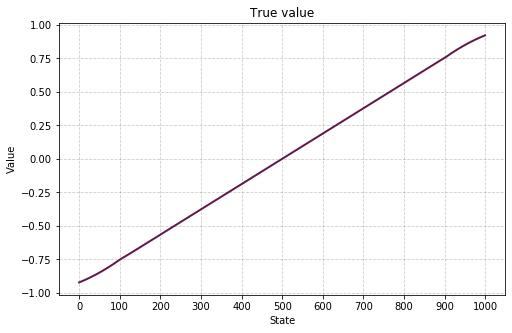

In [77]:
true_values = np.load('true_values.npy')

plt.title('True value')
plt.xlabel('State')
plt.ylabel('Value')
plt.xticks(np.arange(1001, step=100))
plt.grid(True)
plt.plot(true_values, c='#601A4a');

Implement the RMS error function:

In [78]:
def rms_error(values, true_values):
    """Computes the root-mean-squared error.
    - values: The predicted values.
    - true_values: The true values.
    """
    #########################
    
    return np.sqrt(np.mean((values-true_values)**2))
    
    #########################

### Prediction

Now we will actually predict the values. The function below runs the semi-gradient TD(0) algorithm  
multiple times and computes the RMS error after each episode. The values and the RMS errors are  
averaged over the runs.

In [147]:
def run_prediction(env, true_values, value_cls, alpha, gamma, num_episodes, num_runs):
    avg_values = np.zeros(1000)
    avg_rms_errors = np.zeros(num_episodes)
    
    for run in range(1, num_runs + 1):
        print('\rRun: {}/{}'.format(run, num_runs), end='', flush=True)
        
        value_fn = value_cls()
        
        for episode in range(num_episodes):
            value_fn.train(env, alpha, gamma)
            avg_rms_errors[episode] += rms_error(value_fn.values(), true_values)
        
        avg_values += value_fn.values()
    
    avg_values /= num_runs
    avg_rms_errors /= num_runs
    return avg_values, avg_rms_errors

We will predict the values for both types of feature vectors.  
The random seeds should be the same to make the results comparable.  

First we will use the **one-hot encoded features**:

In [148]:
np.random.seed(13)
avg_values_one_hot, avg_rms_errors_one_hot = \
    run_prediction(env, true_values, OneHotValueFunction, alpha=0.5, gamma=1, num_episodes=3000, num_runs=5)

Run: 1/5

TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

Then we will use **state aggregation**:

In [ ]:
np.random.seed(13)
avg_values_state_aggr, avg_rms_errors_state_aggr = \
    run_prediction(env, true_values, StateAggregationValueFunction, alpha=0.1, gamma=1, num_episodes=3000, num_runs=5)

### Plots

After successfully running the prediction algorithm, we visualize the results:

In [ ]:
plt.title('Semi-gradient TD(0) results')
plt.xlabel('State')
plt.ylabel('Value')
plt.plot(avg_values_one_hot, c='#63ACBE', label='One-hot')
plt.plot(avg_values_state_aggr, c='#EE442F', label='State aggregation')
plt.plot(true_values, c='#601A4a', label='True values')
plt.xticks(np.arange(1001, step=100))
plt.grid(True)
plt.legend();

In [ ]:
plt.xlabel('Episode')
plt.ylabel('RMS error')
plt.plot(avg_rms_errors_one_hot, c='#63ACBE', label='One-hot')
plt.plot(avg_rms_errors_state_aggr, c='#EE442F', label='State aggregation')
plt.legend();